<a href="https://colab.research.google.com/github/sreejadeb1997/training-data-analyst/blob/master/hw5_key_value_memory_network_assignment_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preamble

This mini-project involves working through all the steps of a problem, whereas prior assignments asked you to just implement core functions. We will give you a dataset, but you will also have the opportunity to manipulate the data in ways that you find beneficial to the overall project and to explain why and how those manipulations mattered. This will be in addition to building the model from scratch, developing the training loop, and implementing testing. The code will be accompanied by a report written into the notebook.

This project will have you working with attention mechanism, in a new type of system for question-answering. This will provide you with experience working with attention mechanisms while not directly working with transformers.

This assignment is not autograded. You can modify any code cells as long as you achieve the requirements of each graded component.

# Introduction

Memory networks learn to access external memory stores (a database or, in the case of this assignment, a dictionary). Key-Value Memory Networks specifically assume that the external memory store is organized as a dictionary with keys and values. In theory memory networks are useful when one wants a neural network to be able to know a lot of information but we don't want to try to encode that information directly into the parameters of the network. This means information can be changed in the external memory database without retraining the neural network.

Given a question, e.g., "Where was Alexander Hamilton born?", a key-value memory network learns an embedding such that the question has a high cosine similarity to a particular key in the external dictionary. Because there are many keys that need to be matched against, key-value memory networks implement an attention-scoring mechanism to select a key. Because attention is a probabilistic score, the key-value memory network retrieves a sum of embeddings weighted according to the attention score. This weighted embedding is then compared to values using a second attention-scoring mechanism. The value with the highest cosine similarity can then be retrieved and returned as the answer.

Memory networks were an important part of the evolution of question-answering systems that have been eclipsed by transformers. However, the attention mechanism in a key-value memory network is very similar to the self-attention inside a transformer, so implementing a key-value memory network is a really great way to experiment and learn about self-attention without the added complexity of transformers.

Key-value memory networks are also closely related to retieval-based generation networks, except we will be retrieving facts from a dictionary instead of via the internet. However, the embedding of retrieved data will be similar.

Key-value memory networks are described in this [paper](https://arxiv.org/abs/1606.03126). It is recommended that you read the paper, but we will also walk through the steps you will need to complete.

# Some imports



You may add imports as necessary.

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import re
import os
import json
import random
import numpy as np
import pickle
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Unidecode is useful for getting rid of issues that arise from unicode. This should not be used if we care about unicode, but for the purposes of an instructional exercise, it eliminates a lot of edge cases that come up with unicode.

In [ ]:
!pip install unidecode

In [ ]:
import unidecode

If you need to have a reduced vocabulary, you can create an unknown "unk" token and add it to the vocabulary. Make sure the token index in the vocabulary and `UNK_ID` match.

In [ ]:
UNK = 'unk'
UNK_ID = '0'

# Some utilities

You may edit these as necessary.

Stem words

In [ ]:
# Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= [ps.stem(word) for word in text]
    return text

Simple tokenizer that only keeps letters and numbers.

In [ ]:
def tokenize(line):
    line = re.sub(r'[^a-zA-Z0-9]', ' ', unidecode.unidecode(line)) # remove punctuation
    line = line.lower().split()  # lower case
    return line

    #Tokenize string to convert to list of words, then give to stemming function

A standard vocabulary object class

In [ ]:
class Vocab:
    def __init__(self, name = 'vocab'):
        self.name = name
        self._word2index = {}
        self._word2count = {}
        self._index2word = {}
        self._n_words = 0

    def get_words(self):
      return list(self._word2count.keys())

    def num_words(self):
      return self._n_words

    def word2index(self, word):
      return self._word2index[word]

    def index2word(self, word):
      return self._index2word[word]

    def word2count(self, word):
      return self._word2count[word]

    def add_sentence(self, sentence):
        for word in tokenize(sentence):
            self.add_word(word)

    def add_word(self, word):
        if word not in self._word2index:
            self._word2index[word] = self._n_words
            self._word2count[word] = 1
            self._index2word[self._n_words] = word
            self._n_words += 1
        else:
            self._word2count[word] += 1

Make a bag of words frmo a sentence, given a vocabulary. Can return a bag of word counts or a a bag of word presences.

In [ ]:
def multihot(s, vocab, preserve_counts = False):
  tokens = np.array([vocab.word2index(t) for t in tokenize(s)])
  mhot = np.zeros((tokens.size, vocab.num_words()))
  mhot[np.arange(tokens.size), tokens] = 1
  if preserve_counts:
    return mhot.sum(0)
  else:
    return mhot.sum(0) >= 1


If you have a reduced vocabulary, use this to replace out-of-vocab words. If you use this, you may want to merge it with `multihot` above to avoid tokenizing twice.

In [ ]:
def unkit(s, vocab):
  return ' '.join(list(map(lambda x: UNK if x not in vocab._word2index else x, tokenize(s))))

# Part A: Download and Process Data (0 points)

This dataset contains the information in tables that are commonly used in Wikipedia biography pages. Each person has different rows of information pertaining to their notable accomplishments and details about their life. There are a large number of types of information that can appear as rows in the biography tables, however they are relatively uniform. We call the keys of the rows "relations".

For example [Alexander Hamilton](https://en.wikipedia.org/wiki/Alexander_Hamilton) has information about the President he worked for as Secretary of State, birth date, date of death, parents' names, etc.

The code below will download the dataset and process it to create two things:
- `DB`: a hash table that map titles of biography wikipedia articles to table information. The table information is represented as a nested hash table containing relations as keys, and associated values. For example, `DB['alexander hamilton'] = {'party': 'federalist',
 'spouse': 'elizabeth schuyler', ...}`
- `VOCAB`: A vocabulary object that maps words to tokens and vice versa.

In [ ]:
!git clone https://github.com/rlebret/wikipedia-biography-dataset.git

Cloning into 'wikipedia-biography-dataset'...
remote: Enumerating objects: 93, done.
remote: Total 93 (delta 0), reused 0 (delta 0), pack-reused 93 (from 1)
Receiving objects: 100% (93/93), 338.68 MiB | 25.10 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Updating files: 100% (19/19), done.


In [ ]:
!cat wikipedia-biography-dataset/wikipedia-biography-dataset.z?? > tmp.zip
!unzip -o tmp.zip
!rm tmp.zip

Archive:  tmp.zip
   creating: wikipedia-biography-dataset/test/
  inflating: wikipedia-biography-dataset/test/test.box  
  inflating: wikipedia-biography-dataset/test/test.id  
  inflating: wikipedia-biography-dataset/test/test.nb  
  inflating: wikipedia-biography-dataset/test/test.sent  
  inflating: wikipedia-biography-dataset/test/test.url  
  inflating: wikipedia-biography-dataset/test/test.contributors  
  inflating: wikipedia-biography-dataset/test/test.title  
   creating: wikipedia-biography-dataset/train/
  inflating: wikipedia-biography-dataset/train/train.box  
  inflating: wikipedia-biography-dataset/train/train.id  
  inflating: wikipedia-biography-dataset/train/train.nb  
  inflating: wikipedia-biography-dataset/train/train.sent  
  inflating: wikipedia-biography-dataset/train/train.url  
  inflating: wikipedia-biography-dataset/train/train.contributors  
  inflating: wikipedia-biography-dataset/train/train.title  
   creating: wikipedia-biography-dataset/valid/
  infla

Get all the wikipedia titles.

In [ ]:
train_titles = []
with open("wikipedia-biography-dataset/train/train.title", "r") as file:
  for line in file:
    train_titles.append(line.rstrip())

Boxes contain all the information, with each line corresponding to a title in `titles`.

In [ ]:
train_boxes = []
with open("wikipedia-biography-dataset/train/train.box", "r") as file:
  for line in file:
    train_boxes.append(line.rstrip())

This will make the DB object, a dictionary of dictionaries for each wikipedia title, which is more or less the same as names. This function only keeps politicians (containing the "office" key term) and strips out information about images. It can be improved in many ways.

In [ ]:
# Make a dictionary of dictionaries
def make_db(titles, boxes):
  db = {} # The DB
  # Iterate through titles
  for i in tqdm(range(len(titles))):
    box = boxes[i] # Grab the corresponding box information
    d  = {} # Inner dictionary
    # Build a dict for the ith entry
    # grab each key:value pair
    for pair in re.findall(r'([a-zA-Z_]+)[0-9]*\:([\w\d]+)', box):
      key, value = pair
      # Do a bit of cleaning
      key = key.strip()
      value = value.strip()
      # If the key contains the word image, we probably don't want to keep it
      if 'image' not in key:
        # The regex maintains underscores, strip those off
        if key[-1] == '_':
          key = key[:-1]
        # Make a new entry in inner dictionary if we don't have one
        if key not in d:
          d[key] = value
        # Keys with compound values are split up, which is annoying, so put them back together
        else:
          d[key] += ' ' + value
    # If it has an office key, keep it.
    if 'office' in d:
      db[titles[i]] = d
  return db

Build the vocab from the DB. Convert the whole thing into a string, tokenize it, and feed the surviving words into the vocab.

In [ ]:
def make_vocab(DB):
  # Make the vocab object
  vocab = Vocab()
  # Tokenize the data by converting the entire DB into a string
  tokens = tokenize(str(DB))
  # Iterate through all the tokens (tqdm provides a progress bar)
  for t in tqdm(tokens):
    vocab.add_word(t)
  return vocab

If you want to discard rare words, this will rebuild the vocab. This is just an example.

In [ ]:
def reduce_vocab(vocab, min_word_occurrence = 2):
  # make a new vocab
  vocab2 = Vocab("top")
  # Add the UNK token
  vocab2.add_word(UNK)
  # Iterate through vocabulary
  for w in list(vocab._word2count.keys()):
    count = vocab._word2count[w]
    idx = vocab._word2index[w]
    # If the word count passes threshold, add it to the new vocabulary object
    if count >= min_word_occurrence:
      vocab2.add_word(w)
      vocab2._word2count[w] = count
  # Return the new vocabulary object
  return vocab2

Make the DB

In [ ]:
DB = make_db(train_titles, train_boxes)

100%|██████████| 582659/582659 [00:36<00:00, 15829.38it/s]


In [ ]:
print(DB.keys())
#print top 2 entries
print(list(DB.items())[:1])

dict_keys(['j. p. featherston', 'jon tester', 'emanuelis zingeris', 'jean-marie le pen', 'ma lik', 'w. b. kinne', 'antonio nariño', 'chang nien-chung', 'thomas claiborne -lrb- 1749 -- 1812 -rrb-', 'qi jinli', 'merrill i. mills', 'wang guosheng -lrb- politician -rrb-', 'thomas holliday hicks', 'robert smith walker', 'josiah carter', 'pavol hrivnák', 'h. m. fowler', 'kala venkata rao', 'mohammed al-ghabban', 'ian khama', 'joe lesage', 'beatrice ask', 'monica ell', 'samuel prowse', 'patrick utomi', 'sarah alade', 'tom christensen', 'ivica kirin', 'wesley c. uhlman', 'baljit singh jalal usma', 'Émery lalonde , jr. .', 'stanisław lamczyk', 'hanna gronkiewicz-waltz', 'thomas patrick thornton', 'abdirahman jama barre', 'mortimer sellers', 'camille mather', 'robert taschereau', 'kevin mannix', 'joseph unwin', 'shahabuddin ahmed', 'wilmot james', 'chris watson', 'terry mills -lrb- australian politician -rrb-', 'kate ellis', 'eric louw', 'durga prasad bhattarai', 'malcolm shepherd , 2nd baron sh

Make the VOCAB

In [ ]:
VOCAB = make_vocab(DB)
print(VOCAB.num_words())

100%|██████████| 2997937/2997937 [00:01<00:00, 1831758.36it/s]


96093


## Save Processed Data

You may find it useful to save the processed dataset to your Google Drive.

It is recommended that you save the file to your Google Drive. To mount your Google Drive, open the file icon on the left side of the screen to get to the option). To save the file in your Google Drive use the path `'drive/MyDrive/filename'`.)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open("drive/MyDrive/data", "wb") as f:
  pickle.dump(DB, f, protocol=None, fix_imports=True, buffer_callback=None)

In [ ]:
with open('drive/MyDrive/vocab', 'wb') as f:
    pickle.dump(VOCAB, f, protocol=None, fix_imports=True, buffer_callback=None)

## Load processed data

If you have saved the processed data in your Google Drive, you can re-load it with these commands.

In [ ]:
with open("drive/MyDrive/vocab", "rb") as f:
  VOCAB = pickle.load(f)

In [ ]:
with open("drive/MyDrive/data", "rb") as f:
  DB = pickle.load(f)

In [ ]:
print(VOCAB.word2index("hamilton"))

1548


## Data example

Get to know your data.

In [ ]:
DB["alexander hamilton"]

{'name': 'alexander hamilton',
 'office': '1st united states secretary of the treasury senior officer of the army delegate to the congress of the confederation from new york',
 'president': 'george washington john adams',
 'term_start': 'september 11 1789 december 14 1799 november 3 1788 november 4 1782',
 'term_end': 'january 31 1795 june 15 1800 march 2 1789 june 21 1783',
 'predecessor': 'position established george washington egbert benson seat established',
 'successor': 'oliver wolcott jr james wilkinson seat abolished seat abolished',
 'birth_date': '11 january 1755',
 'birth_place': 'charlestown nevis british west indies',
 'death_date': 'july 12 1804 aged 47 or 49',
 'death_place': 'new york city new york u',
 'party': 'federalist',
 'spouse': 'elizabeth schuyler',
 'children': 'philip angelica alexander james alexander john church william stephen eliza holly phil',
 'alma_mater': 'kings college new york',
 'religion': 'presbyterian episcopalian convert',
 'signature': 'alexan

# Part B: Implement the Key-Value Memory Network (10 points)

This [paper](https://arxiv.org/abs/1606.03126) describes the key-value memory networks in detail, which is also sketched out below.

A key-value memory network takes a natural language question. This question will be converted into a bag-of-words (i.e., a multihot) Call this $x$ and it is a 1D tensor of vocabulary length.

![KVMemNet architecture](https://github.com/markriedl/kvmemnet-assignment/blob/32479dd1e88a9f8dfc72f11ccb8e9e0e1f78905f/kvmemnet-inside.png?raw=true)

The KVMemNet will contain a linear layer (or embedding layer) that will produce a 1D embedding of the question $q=A(x)$.

The KVMemNet will also take in a stack of keys as a tensor of shape `num_keys x vocab_size`. Each row is embedded using the same embedding, $k=A(keys)$, producing a tensor of shape `num_keys x embed_dim`. How this stack of keys is chosen will be discussed below.

The KVMemNet will take in a third input, a stack of values associated with the stack of keys. This will also be of shape `num_values x vocab_size`. Each row is embedded using the same embedding, $v=A(values)$, producing a tensor of shape `num_keys x embed_dim`.

The KVMemNet will also contain a second linear embedding layer, $B$. More on this later.

Once we have `q`, `k`, and `v` embeddings, the next step is to use `q` and `k` to compute attention scores that can be applied against `v`. Think of $A$ as learning how to make questions and the keys that should match against values that have received the same treatment.

The attention scores `p` are computed by taking the inner-product (`torch.inner()`) between `q` and `k`. The result will be a 1D tensor with `num_keys` length. Use softmax so that `p` contains scores between 1.0 and 0.0.

You may be wondering why there isn't a non-linearity such as a sigmoid or ReLU after the linear layer. Softmax is a non-linearity.

Next apply the `p` attention scores against `v` to apply a weight against each value in the stack of values. One should be highly weighted and the rest less weighted. Sum all the weighted values up to create a 1D tensor `o` of feature weights of length `embed_dim`. `p` can be thought of as how much of each value gets selected. Then they all get combined together and the feature weights are proportional to how much each value was attended to. The `torch.matmul()` can do the multiplication and summing in one step.

The KVMemNet forward function should return this tensor of feature weights `o`.

A quick note on `k` and `v`. We can't send the entire set of keys and values in our database through the network's forward function. Instead there should be a selection mechanism that selects just a subset of the database. This subset should contain the best key for the question $x$ to match against, and its corresponding value. We assume that a shallow selection process can narrow down the key-value pairs to a relatively small set, one of which will be best. For example, if the question involves "Alexander Hamilton", we can reasonably guess that the best key-value pair is in the part of the database associated with the named person.

We are not done though. What about our linear layer $B$? Suppose variable `Y` contains our entire set of values in our databse as bags of words. $B$ is going to be used to embed our entire set of database values $y=B(Y)$. $B$ can be thought of as learning how to make all the values look like the feature weights output by the model such that the highest cosine similarity corresponds to the correct value taken from *all* values in the database.

$B$ should live inside the KVMemNet object so that its parameters become trainable, but notice that we do not use $B$ in the KVMemNet's forward function. $B$ will get used to prepare the stack of all values in the database for training. It will bet used in the training loop but outside of the forward function. This is a bit unusual, but necessary to figure out the correct target (the true index of the best value to match against) for training.

The above explantion only implements *single-hop* retrieval. *multi-hop* retrieval allows the results of one retrieval to inform a second (and third and so on) to get the right retrieval. This would be used in the case where the answer cannot be inferred directly from the question in a single retrieval, such as "What was the founding date of the country that Alexander Hamilton was born in?". To implement multi-hop retrieval, the KVMemNet will have additional linear layers $R_1...R_n$. Each $R_{i}$ will do a linear transform on `q` then attention will score and retrieve values as feature weights `o`. This will be sent to the next $R_{i+1}$ and so on until the hops are complete. This final `o` will be returned.

For this assignment is is sufficient to only do *single-hop* retrieval.

The above explanation does not include consideration of batching. You may want to add a batch dimension as the first dimension and input a batch as a set of questions, a set of stacks of keys, and a set of stacks of values. To do this, functions like `.inner()`, `.mm()`, and`.matmul()` will not work. Instead use `.bmm()` which handles batching correctly. You will probably need to do some `.squeeze()` and `.unsqueeze()` operations to make sure your tensors are the correct shapes.

Instead of bag-of-words, one may also consider first converting each question, key, and value into a general set of embeddings such as [GLoVe](https://nlp.stanford.edu/projects/glove/). To do this one will need to consider how to combine words--convert each word into an embedding vector and then add the vectors together (or maybe average them).

**Complete the key-value memory net code**

In [ ]:
#batching done - check if the training can be done in batches to reduce time?
class KVMemNet(nn.Module):
  def __init__(self, vocab_size, embed_dim):
    super(KVMemNet, self).__init__()
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim
    ### YOUR CODE HERE

    self.A=nn.Linear(vocab_size, embed_dim)
    self.B=nn.Linear(vocab_size, embed_dim)
    self.softmax=nn.Softmax(dim=1)

  def forward(self, x, keys, values):
    output = None
    ### YOUR CODE BELOW
    # x=[batch_size, vocab_size]--> q=[batch_size, embed_dim]
    # k=[batch_size, num_keys, vocab_size]--> [batch_size, num_keys, embed_dim]
    # v=[batch_size, num_keys, vocab_size]--> [batch_size, num_keys, embed_dim]

    batch_size=x.shape[0]
    num_keys=keys.shape[1]

    q=self.A(x) #[batch_size, embed_dim]
    k=self.A(keys) #[batch_size, num_keys, embed_dim]
    v=self.A(values) #[batch_size, num_keys, embed_dim]

    q=q.unsqueeze(1)  #[batch_size, 1, embed_dim]
    p=torch.bmm(q, k.transpose(1, 2)).squeeze(1)  #[batch_size, 1, embed_dim] bmm [batch_size, embed_dim, num_keys] = [batch_size, 1, num_keys] --> squeeze at 1 = [batch_size, num_keys]
    p=self.softmax(p)


    p=p.unsqueeze(1)  #[batch_size, 1, num_keys]
    output=torch.bmm(p, v).squeeze(1)  #[batch_size, 1, num_keys] bmm [batch_size, num_keys, embed_dim] = [batch_size, 1, embed_dim] --> squeeze at 1 = [batch_size, embed_dim]

    ### YOUR CODE ABOVE
    return output


# Synthetic Data Set

This is a synthetic dataset. One way to test a model during development is to take a small piece of data and show that you can overfit a model. If you can't overfit an easily learned chunk of data, then you probably have something wrong in your code. In this case I have provided a small chunk of synthetic data that should be easy to learn.

- The vocabulary is 20 word: 5 names, 5 relations, 5 question-words, 5 values
 - First 5 elements of the vocab are names (for example index 0 might be "Hamilton").
 - Second 5 elements of the vocab are relations (for example, "born", "died", "occupation").
 - Third 5 elements are random words that might be part of a query (for example, "When was").
 - Final 5 elements of the vocab are possible values (for example, "1757")
- A "question" is a name (5, 1), relation (5, 1), some words (5, 1), and no values
- The keys will all have the same name (5, 5) where each row is idential, relations (5, 5), no words, no values
- Values will have no names, no relations, no words, and value vocab words

In [ ]:
# Turn on a different relation on each row
relations = torch.zeros(5, 5)
relations.fill_diagonal_(1)

# training data
train_data = {}
for i in range(5):
  # Name associated with questions, keys, values
  '''
  train_data[0] for the same person Hamilton(repeated 5 times), 5 relation, 5 question-words, 5 values corresponding

            questions [5,20] - stacks name, relation, words, values horizontally --> "Hamilton (1X5) Born(1X5) When(1X5) zero(1X5)" 5 such rows for 5 different questions regarding hamilton
              name (5, 5) -> Name
              relation (5, 5) -> Relations
              words (5, 5) -> Random question words
              values (5, 5) -> No values

            keys [5,20] --> "Hamilton (1X5) Born(1X5) zero(1X5) zero(1X5)" 5 such rows
              name (5, 5) -> Name
              relation (5, 5) -> Relations
              words (5, 5) -> No question words
              values (5, 5) -> No values

            values [5,20] --> "zero (1X5) zero(1X5) zero(1X5) 1755(1X5)" 5 such rows
              name (5, 5) -> No Name
              relation (5, 5) -> No Relations
              words (5, 5) -> No  question words
              values (5, 5) -> values




  Y --> "zero (1X5) zero(1X5) zero(1X5) 1755(1X5)" 5 such rows for 5 different values from train[0] Hamilton, 5 such for all train
          extracts the 'values' tensor ((5, 20)) from each train_data[i]
          Stacks all 5 (5 training points) vertically
          [5* 5, 20] --> [25, 20]
  '''
  train_data[i] = (torch.cat([F.one_hot(torch.arange(0, 5))[i].repeat(5, 1),
                         relations,
                         torch.randint(0, 2, (5, 5)).float(),
                         torch.zeros(5, 5)], dim=1),
              torch.cat([F.one_hot(torch.arange(0, 5))[i].repeat(5, 1),
                         relations,
                         torch.zeros(5, 5),
                         torch.zeros(5, 5)], dim=1),
              torch.cat([torch.zeros(5, 5),
                         torch.zeros(5, 5),
                         torch.zeros(5, 5),
                         torch.randint(0, 2, (5, 5)).float()], dim=1))
  Y = torch.cat([v[2] for v in list(train_data.values())], dim=0)#.to('cuda')

# Part C: Train on Synthetic Data (5 points)

The following describes the steps to set up a training loop, including the training of the $B$ layer.

![The KVMemNet being used in the training loop](https://github.com/markriedl/kvmemnet-assignment/blob/main/kvmemnet-outside.png?raw=true)

- Create a model with the given vocabulary size and an embedding size that is equal to or smaller.
- Loop through `N` epochs:
 - There are five names, loop through each name.
   - Get a stack of questions, stack of keys, and stack of values from `DB_synth`.
   - Loop through the relations. There is relation on each row of the keys and values.
     - Get a single question, the `i`-th row in the questions pulled from `DB_synth` above.
     - Compute the target: this is the `name*5 + i` element in `Y`.
     - Run the singular question, stack of keys, and stack of values through the model and produce an output, which is a tensor of feature weights.
     - Run all of `Y` through `model.B()` to get an embedded stack of values.
     - Take the softmax of the inner product between the embedded stack of values from `Y` and the feature weight generated by the model.
     - Compute the loss with `nn.CrossEntropyLoss`.
     - Call `.backward()` on the loss.

In addition to printing the loss (after every question or after every name in `DB_synth`) you can also print the target and the argmax of the softmax result to see if they match. Over time you should see the target and the argmax in agreement. For the purposes of this part of the project it is sufficient to test on the training set.

Don't forget to move the model and the tensor to the GPU.

You may want to speed up training by implementing batching. To do this, the model `forward()` needs to take tensors with an extra batching dimension as the first dimension. However, `.inner()`, `.mm()`, and `.matmul()` will not work properly. You will need to use `.bmm()` instead, which understands the first dimension is for batching. You will likely find that you need to perform some `.squeeze()` and `.unsqueeze()` operations. You can try batch-size of one, or take entire chunks (or even all synthetic data as a single, large batch). Try it different ways.

Try training on the synthetic data first.

You may make as many cells as necessary. Save your notebook outputs that plot loss and show it reducing.

**Write code blocks below that create the `KVMemNet`**

In [ ]:
# Set up your KVMemNet, move it to the GPU, setup up optimizer (e.g., Adam), and criterion.
vocab_size=20
embed_dim=10
model=KVMemNet(vocab_size, embed_dim)#.to('cuda')  #move it to the GPU

optimizer=optim.Adam(model.parameters(), lr=0.001)

criterion=nn.CrossEntropyLoss()

**Write and run a training testing loop. Show that your training loop loss converges with a plot**

To plot a loss curve, compute the mean loss per epoch and save it in a list:
```
x_axis.append(epoch_number)
y_axis.append(mean_epoch_loss_for_this_epoch)
plt.plot(x_axis, y_axis)
plt.show()
```

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# import matplotlib.pyplot as plt


# epochs = 1
# batch_size = 2  # Using batch size of 2 for this example
# train_losses = []  # for plotting


# for epoch in range(epochs):
#     model.train()
#     epoch_loss = 0.0

#     for i in range(0, len(train_data), batch_size):
#         # Get a batch of questions, keys, and values
#         batch_questions = []
#         batch_keys = []
#         batch_values = []
#         for j in range(i, min(i + batch_size, len(train_data))):
#             question, keys, values = train_data[j]
#             batch_questions.append(question[0]) #questions repeated 5 times, hence the size was coming as (batch X 5 X vocab). consider just one row
#             batch_keys.append(keys)
#             batch_values.append(values)

#         # Stack the batch data (batch_size, vocab_size), (batch_size, num_keys, vocab_size), (batch_size, num_keys, vocab_size)
#         batch_questions = torch.stack(batch_questions).cuda()
#         batch_keys = torch.stack(batch_keys).cuda()
#         batch_values = torch.stack(batch_values).cuda()

#         print("q,k,v sizes:" ,batch_questions.size(), batch_keys.size(), batch_values.size())

#         # Get target Y for the batch
#         print("Y: ",Y.size())
#         target = Y[i:i + batch_size * 5].to('cuda')
#         print("target: ",target.size())

#         # Forward pass
#         output = model(batch_questions, batch_keys, batch_values)  # [batch_size, embed_dim]
#         print("output: ",output.size())
#         output = output.unsqueeze(2)
#         print("output: ",output.size())

#         # Embed the values using model.B
#         embedded_values = model.B(Y)#.unsqueeze(1)  # [batch_size, num_values=25, embed_dim]
#         print("Y: ", embedded_values.size())
#         Y_expanded = embedded_values.unsqueeze(0).expand(batch_size, -1,-1)
#         print("Y: ", Y_expanded.size())

#         softmax_output = torch.bmm(Y_expanded, output).squeeze(2)  #[25, 1, 10] bmm [1, 10, 1]        [batch_size, 25]
#         print("softmax_output: ",softmax_output.size())


#         # Accumulate loss
#         loss = criterion(softmax_output, target)
#         epoch_loss += loss.item()

#         # Backward pass
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # Predicted class as the highest prob in output
#         predicted = softmax_output.argmax(dim=1)
#         print(f"Epoch [{epoch+1}/{epochs}], Batch {i+1}/{len(train_data)//batch_size} Loss: {loss.item():.4f}")
#         print(f"Target: {target}")
#         print(f"Predicted: {predicted}")

#     # Average loss for the epoch
#     epoch_loss /= len(train_data) // batch_size  # Number of batches
#     train_losses.append(epoch_loss)
#     print(f"Epoch [{epoch+1}/{epochs}] Average Loss: {epoch_loss:.4f}\n")

# # Plotting the training loss over epochs
# plt.plot(train_losses)
# plt.title('Training Loss over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()


Target:  20
Predicted: 10
Target:  21
Predicted: 3
Target:  22
Predicted: 2
Target:  23
Predicted: 23
Target:  24
Predicted: 24
Epoch 100/500, Loss: 1.1655
Target:  20
Predicted: 10
Target:  21
Predicted: 21
Target:  22
Predicted: 2
Target:  23
Predicted: 23
Target:  24
Predicted: 12
Epoch 200/500, Loss: 0.7903
Target:  20
Predicted: 10
Target:  21
Predicted: 21
Target:  22
Predicted: 2
Target:  23
Predicted: 23
Target:  24
Predicted: 24
Epoch 300/500, Loss: 0.7571
Target:  20
Predicted: 10
Target:  21
Predicted: 21
Target:  22
Predicted: 2
Target:  23
Predicted: 23
Target:  24
Predicted: 12
Epoch 400/500, Loss: 0.7510
Target:  20
Predicted: 10
Target:  21
Predicted: 21
Target:  22
Predicted: 2
Target:  23
Predicted: 23
Target:  24
Predicted: 12
Epoch 500/500, Loss: 0.7496


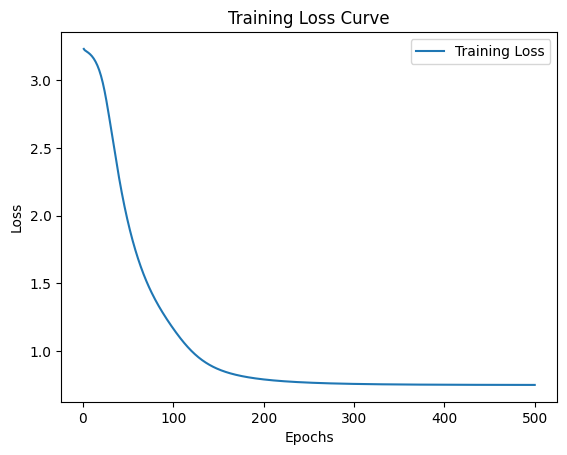

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


epochs = 500 #100
batch_size = 1  # Using batch size of 1 for this example
train_losses = []  # for plotting

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    # Loop over batches (each batch is a slice of 5 rows for this example)
    for name_index in range(5):
        questions, keys, values = train_data[name_index]
        keys=keys#.to('cuda')
        values=values#.to('cuda')

        for relation_index in range(5):
          question=questions[relation_index]#.to('cuda')
          # print("q,k,v sizes:" ,question.size(), keys.size(), values.size())
          output = model(question.unsqueeze(0), keys.unsqueeze(0), values.unsqueeze(0))
          output=output.squeeze(0)
          # print("output: ",output.size())

          # print("Y: ", Y.size())
          embedded_Y = model.B(Y)
          # print("embedded_Y: ", embedded_values.size())

          softmax_output = torch.inner(embedded_Y, output)
          # print("softmax_output: ",softmax_output.size())

          target_index=torch.tensor(name_index*5+relation_index)#.to('cuda')
          # print("target_index: ",target_index.size())


          # Accumulate loss
          loss = criterion(softmax_output, target_index)
          epoch_loss += loss.item()

          # Backward pass
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()


          # Predicted class as the highest prob in output
          predicted = softmax_output.argmax(dim=0)

          if (epoch + 1) % 100 == 0 and name_index==4:  # Print loss every 100 epochs and last name just to reduce verbose print
              # print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
              print(f"Target: ",target_index.item())
              print(f"Predicted: {predicted}")

    avg_loss = epoch_loss / (5 * 5)  # Normalize by total iterations
    train_losses.append(avg_loss)

    if (epoch + 1) % 100 == 0:  # Print loss every 50 epochs
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Plot loss over epochs
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()







# Part D: Training on the Full Data (10 points)

To train on the full data, you are going to need to do some pre-processing of the data.

First, there are no "questions". You need to generate questions for each type of relation. There a number of ways to do this. The simplest is to just assume that a question is the name of a person and a relation, e.g., "Alexander Hamilton birth date". Another way would be to create templates for each type of relation. For example the "birth date" relation would have the following template: "When was [name] born?", filling in the [name]. Because there are a lot of different types of relations, you may want to remove the more obscure relations so you need fewer templates and also have a smaller vocabulary. Templates work well if the questions are expected to be almost identical to the templates. You may want to generate multiple templates per relation. Continuing the previous example, a second template would be: "What is the birthdate of [name]?".

If you are feeling more ambitious, you could use GPT-J, GPT-NeoX, GPT-3 or ChatGPT to generate templates. It works decently well and you can get some variety of templates.

The question should contain information about the person and some words that are representative of the relation even if the exact relation words aren't used (the KVMemNet should figure out that "birthdate" and "born" are correlated).

You only put a subset of all key-value pairs into the KVMemNet. You need a technique for sub-selecting from all the key-value pairs in `DB`. You might just need the ones that are directly associated with the person (Alexander Hamilton has 23). You may need to mix in a few key-value pairs from another person's entries in the database to help ensure against accidental overfitting.

The final challenge you will have in the training loop is that there may still be too many unique values in `Y` to encode and create one big tensor. In that case, you can at least use the values that you sent to the KVMemNet, along with as many other randomly selected values as you can fit into the GPU's memory.

Create as many cells below as you need. Save the output of your training and testing functions, reporting loss during training and accuracy during testing. 5 points for a training loop that reduces loss. 5 points for a training function with a correct accuracy computation.

**Create a training dataset and a non-overlapping testing dataset**

If CPU memory becomes a problem you might want to consider a `DataLoader` so that data can be stored on file and pulled up when needed.

In [ ]:
# Create your training and test sets here

In [ ]:
def multihot(s, vocab, preserve_counts = False):
  tokens = np.array([vocab.word2index(t) for t in tokenize(s)])
  mhot = np.zeros((tokens.size, vocab.num_words()))
  mhot[np.arange(tokens.size), tokens] = 1
  if preserve_counts:
    return (mhot.sum(0)).astype(np.float32)
    # return torch.tensor(mhot.sum(0))
  else:
    return (mhot.sum(0) >= 1).astype(np.float32)
    # return torch.tensor(mhot.sum(0) >= 1)

mhot=multihot("alexander hamilton", VOCAB)
print(mhot)
indices = np.nonzero(mhot == 1)
print(indices)

[0. 0. 0. ... 0. 0. 0.]
(array([1548, 2267]),)


In [ ]:

d=[]
for name, content in DB.items():
  # print(name,content)
  person=[]
  for key, value in content.items():
    if "birth" in key or "death" in key or "office" in key:
      # print(name, "-" , key, "-" , value)
      tmp = [name, "{} {}".format(name, key), "{} {}".format(name, value)]
      person.append(tmp)
  d.append(person)

train_num=10 #100
test_num=train_num+10
train_data=d[:train_num]
test_data=d[train_num:test_num]

train_data[0]

[['j. p. featherston',
  'j. p. featherston birth_date',
  'j. p. featherston november 28 1830'],
 ['j. p. featherston',
  'j. p. featherston birth_place',
  'j. p. featherston durham county durham'],
 ['j. p. featherston',
  'j. p. featherston death_date',
  'j. p. featherston 1917'],
 ['j. p. featherston',
  'j. p. featherston death_place',
  'j. p. featherston ottawa'],
 ['j. p. featherston',
  'j. p. featherston office',
  'j. p. featherston mayor of ottawa']]

**Create your `KVMemNet`**

In [ ]:
# Set up your KVMemNet here
vocab_size=VOCAB.num_words()
embed_dim=100
model=KVMemNet(vocab_size, embed_dim)#.to('cuda')  #move it to the GPU

optimizer=optim.Adam(model.parameters(), lr=0.001)

criterion=nn.CrossEntropyLoss()

**Write and run a training loop, showing a loss plot**

You may find it handy to also test your network on the test data periodically as it trains.

Epoch 1/10, Loss: 0.9753
Epoch 2/10, Loss: 0.7087
Epoch 3/10, Loss: 0.6196
Epoch 4/10, Loss: 0.5639
Epoch 5/10, Loss: 0.4568
Epoch 6/10, Loss: 0.3491
Epoch 7/10, Loss: 0.2857
Epoch 8/10, Loss: 0.2324
Epoch 9/10, Loss: 0.1725
Epoch 10/10, Loss: 0.1253


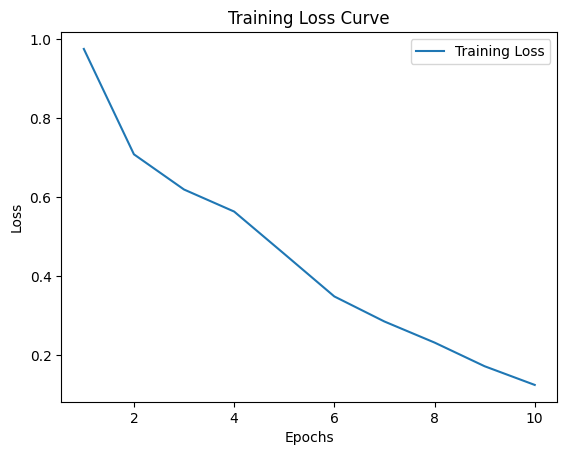

In [ ]:
# Training loop goes here


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


epochs = 10 #500 #100
train_losses = []  # for plotting

# #Creating the entire BOW of values. But the recitation showed we are attempting to figure out in the person specific BOW only thus used B(value for that person) and not B(Y_encoded)
# Y = [row[2] for row in train_data[0]] #torch.cat([v[2] for v in list(train_data.values())], dim=0)#.to('cuda')
# Y_encoded=[multihot(row, VOCAB) for row in Y]
# Y_encoded=torch.tensor(Y_encoded)#.to('cuda')
# Y_encoded.size()


for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    # Loop over batches (each batch is a slice of 5 rows - birtdate, birthplace,deatdate, deathplace, office)
    for name_index in range(train_num):
        # print("name_index: ", name_index)
        batch_data = train_data[name_index]
        # print("batch_data shape: ", batch_data)
        keys=[multihot(row[1], VOCAB) for row in batch_data]
        values=[multihot(row[2], VOCAB) for row in batch_data]
        keys=torch.tensor(keys)#.to('cuda')
        values=torch.tensor(values)#.to('cuda')




        for relation_index in range(len(batch_data)): #5 relations - birtdate, birthplace,deatdate, deathplace, office
          question=keys[relation_index].clone()#.to('cuda')

          # print("q,k,v sizes:" ,question.size(), keys.size(), values.size())
          output = model(question.unsqueeze(0), keys.unsqueeze(0), values.unsqueeze(0))
          output=output.squeeze(0)
          # print("output: ",output.size())

          # print("Y: ", Y.size())
          embedded_Y = model.B(values.clone())
          # embedded_Y = model.B(Y_encoded)
          # print("embedded_Y: ", embedded_values.size())

          softmax_output = torch.inner(embedded_Y, output)
          # print("softmax_output: ",softmax_output.size())

          target_index=torch.tensor(relation_index)#.to('cuda')
          # print("target_index: ",target_index.size())


          # Accumulate loss
          loss = criterion(softmax_output, target_index)
          epoch_loss += loss.item()

          # Backward pass
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()


          # Predicted class as the highest prob in output
          predicted = softmax_output.argmax(dim=0)

          # if (epoch + 1) % 100 == 0 and name_index==4:  # Print loss every 100 epochs and last name just to reduce verbose print
          #     # print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
          #     print(f"Target: ",target_index.item())
          #     print(f"Predicted: {predicted}")

          # print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
          # print(f"Target: ",target_index.item())
          # print(f"Predicted: {predicted}")

    avg_loss = epoch_loss / (5 * train_num)  # Normalize by total iterations = train_num * 5 relations (born-2, death-2, office-1)
    train_losses.append(avg_loss)

    # if (epoch + 1) % 100 == 0:  # Print loss every 50 epochs
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Plot loss over epochs
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

**Write the code for testing your model on the test data**

Your training loop can call the testing loop. But make sure that you do one last test on the model after training completes.

In [ ]:
# Testing loop goes here
correct=0
total=0

# Loop over batches (each batch is a slice of 5 rows - birtdate, birthplace,deatdate, deathplace, office
for name_index in range(10):
    # print("name_index: ", name_index)
    batch_data = test_data[name_index]
    # print("batch_data shape: ", batch_data)
    keys=[multihot(row[1], VOCAB) for row in batch_data]
    values=[multihot(row[2], VOCAB) for row in batch_data]
    keys=torch.tensor(keys)#.to('cuda')
    values=torch.tensor(values)#.to('cuda')




    for relation_index in range(len(batch_data)): #5 relations - birtdate, birthplace,deatdate, deathplace, office
      question=keys[relation_index].clone()#.to('cuda')

      # print("q,k,v sizes:" ,question.size(), keys.size(), values.size())
      output = model(question.unsqueeze(0), keys.unsqueeze(0), values.unsqueeze(0))
      output=output.squeeze(0)
      # print("output: ",output.size())

      # print("Y: ", Y.size())
      embedded_Y = model.B(values.clone())
      # print("embedded_Y: ", embedded_values.size())

      softmax_output = torch.inner(embedded_Y, output)
      # print("softmax_output: ",softmax_output.size())

      target_index=torch.tensor(relation_index)#.to('cuda')
      # print("target_index: ",target_index.size())



      # Predicted class as the highest prob in output
      predicted = softmax_output.argmax(dim=0)

      if target_index==predicted:
        correct+=1
      total+=1

accuracy=correct/total
print(f"Accuracy: {accuracy}")





Accuracy: 0.7878787878787878


**Suggestion:** Once you have a model that has decent accuracy, you may want to save it to your Google Drive using ``torch.save()`` and load it when working on the next part of the assignment using ``torch.load()``.

In [ ]:
#saving best model
path = F"/content/drive/My Drive/kvmemnet_model.pth"
torch.save(model.state_dict(), path)

In [ ]:
#Load the model
path = F"/content/drive/My Drive/kvmemnet_model.pth"
model_reloaded = KVMemNet(vocab_size, embed_dim)
model_reloaded.load_state_dict(torch.load(path))
model_reloaded.eval()


KVMemNet(
  (A): Linear(in_features=96093, out_features=100, bias=True)
  (B): Linear(in_features=96093, out_features=100, bias=True)
  (softmax): Softmax(dim=1)
)

# Part E: Use the Model (5 points)

Given a question in natural language, turn it into a bag of words and feed it into the model with a set of plausible keys and values. Apply the output feature embedding to the full set of values and pick the value with argmax. Return the actual text inside that value (not the bag of words or embedding).

That is, given a natural language question, you are asked to create the $q$ and pick a relevant subset of $k$ and $v$. Run the $q$, $k$, and $v$ through the model and get an answer to the original question.

For example a question might be "When was Alexander Hamilton born?" Depending on how you pre-proessed your data, you may need to extract the entity and the relation.

Write a function that takes in the `question` below, the data, and the model, and outputs the text answer, e.g., "11 january 1755". You must use your ``KVMemNet``.

**Suggestion:** To process a question you will probably want to find the entity and the relation. You may use packages such as [NLTK](https://www.nltk.org/) (already imported), [SpaCY](https://spacy.io/), [Stanza](https://stanfordnlp.github.io/stanza/), or other.

Change the question to test your implementation, but don't delete this cell.

In [ ]:
question = "When was alexander hamilton born?"

**Create your function for using the `KVMemNet` to answer a given question.**

The function should take in the question, data, model, and any other parameters you need. The function should return a text string.

You can create as many cells as necessary. Save the notebook cells showing one example of your input question and output answer. For grading we will look to see that your question is in natural language, the model is used, and the answer is in text. The example doesn't have to be correct. You will analyze your technique later in the report.

In [ ]:
# Create your functions here

'''
- get 'name' and 'relation' from question
- get the batch of data where DB has the name
- fetch the 'value' from the batch where key matches using the key-value-memory network model

'''

def getanswer(question, data=DB, model=model_reloaded):


  #1. Extract the name and relation from question
  import nltk
  nltk.download('punkt_tab')
  nltk.download('averaged_perceptron_tagger_eng')
  nltk.download('maxent_ne_chunker_tab')
  nltk.download('punkt')
  nltk.download('maxent_ne_chunker')
  nltk.download('words')
  from nltk import word_tokenize, pos_tag, ne_chunk

  words = word_tokenize(question)
  # print(words)
  tagged_words = pos_tag(words)
  # print(tagged_words)
  named_entities = ne_chunk(tagged_words)
  # print(named_entities)

  names = [word for word, tag in tagged_words if tag == 'NN']
  names=names[-1]
  relation = [word for word, tag in tagged_words if tag == 'VBN']
  relation=relation[-1]
  # print("Extracted Names,relation:", names,relation)










  #2. Get the batch where question has the target name person
  target_name= names #'alexander hamilton'

  target_d=[]
  for name, content in DB.items():
    # print(name,"-",content)
    if target_name in name:
      person=[]
      for key, value in content.items():
        if "birth" in key or "death" in key or "office" in key:
          # print(name, "-" , key, "-" , value)
          tmp = [name, "{} {}".format(name, key), "{} {}".format(name, value)]
          person.append(tmp)
      target_d.append(person)

  # print(target_d)






  #3. Get the key to query
  import spacy
  nlp = spacy.load("en_core_web_sm")

  verb = [relation]
  list_keys = [row[1] for row in target_d[0]]

  most_similar_words = {}

  for word1 in verb:
      max_similarity = -1
      most_similar_word = None
      word1_vec = nlp(word1)

      for word2 in list_keys:
          word2_vec = nlp(word2)
          similarity = word1_vec.similarity(word2_vec)

          if similarity > max_similarity:
              max_similarity = similarity
              most_similar_word = word2

      most_similar_words[word1] = most_similar_word

  for word, similar in most_similar_words.items():
      # print(f"Most similar phrase to '{word}' is '{similar}'")
      target_relation =similar #'alexander hamilton birth_date'



  #4. Get corresponding value to the target_relation and name
  batch_data = target_d[0]
  # print("batch_data shape: ", batch_data)
  keys=[multihot(row[1], VOCAB) for row in batch_data]
  values=[multihot(row[2], VOCAB) for row in batch_data]
  keys=torch.tensor(keys)#.to('cuda')
  values=torch.tensor(values)#.to('cuda')




  question=target_relation#.to('cuda')
  question=[multihot(question, VOCAB)]
  question=torch.tensor(question)#.to('cuda')

  # print("q,k,v sizes:" ,question.size(), keys.size(), values.size())
  output = model_reloaded(question, keys.unsqueeze(0), values.unsqueeze(0))
  output=output.squeeze(0)
  # print("output: ",output.size())

  # print("Y: ", Y.size())
  embedded_Y = model.B(values.clone())
  # print("embedded_Y: ", embedded_values.size())

  softmax_output = torch.inner(embedded_Y, output)
  # print("softmax_output: ",softmax_output.size())


  # Predicted class as the highest prob in output
  predicted = softmax_output.argmax(dim=0)

  predicted_text = batch_data[predicted][2]

  # print(f"Predicted: {predicted}")
  # print(f"Predicted Text: {predicted_text}")
  return predicted_text

In [ ]:
predicted_ans=getanswer(question)
print("Question: ", question)
print("Answer predicted: ", predicted_ans)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


Question:  When was alexander hamilton born?
Answer predicted:  alexander hamilton mcdonald march 16 1919


# Part F: Reporting (15 points)

Your report should answer the following three questions:

 **Q1:** What pre-processing of the data did you do? What motivated the design decisions and how did it impact training and any processing of natural language questions (Parts A and D)?

 Hint: This should help one understand any code modifications you made in Parts A and the first part of Part D. But you shouldn't use this to document your code (hopefully you commented your code with code comments and text cells above), but to justify your choices as well as to explain what worked and what didn't work.

 **Q2:** Report on your training on the real data (Part D). Show your loss curve and report on the testing accuracy. There are many ways to implement the training loop, particularly with the choice of keys and values. What decisions did you make when developing your training loop? Justify your decisions. How did they impact the training?

 Hint: This assignment doesn't grade you on how well your model learns---your solution will not be perfect. We focus more on how you worked through the process. This part of the report should show how well your solution worked, but also the intuition for why it works, and to document the things you tried that didn't work.

 **Q3:** Describe your technique on how you process natural language questions (Part E). Provide some examples of your technique answering questions correctly and some examples of your technique answering questions incorrectly. Discuss what causes the failure cases.

 Hint: You are not penalized for incorrectly answered questions---your model will not be perfect---we are looking for honest reflection. Preferably, show the example as code blocks running your model with notebook outputs saved.

 We have provided three prompts below. You can create as many text and code cells as necessary.

**Q1: Report on Data Pre-processing**

Your text here.

**Q2: Report on Training and Testing**

Your text here.

**Q3: Report on Model Use**

Your text here.